In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae
#from utils.metrics import log_rank, cox_estimation

import os
import json

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
folder_path = './dataset/Simulations_4/'  # change to your folder path
results = pd.read_csv(folder_path + 'results_aug_n_samples_600n_features_bytype_6.csv', index_col=0)
treat_effects = np.unique(results.H0_coef.values)
aug_percs = np.unique(results.aug_perc.values)
for col in results.columns:
    results[col] = np.float64(results[col].values)
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_sel = ["HI-VAE_weibull", "Surv-GAN"]

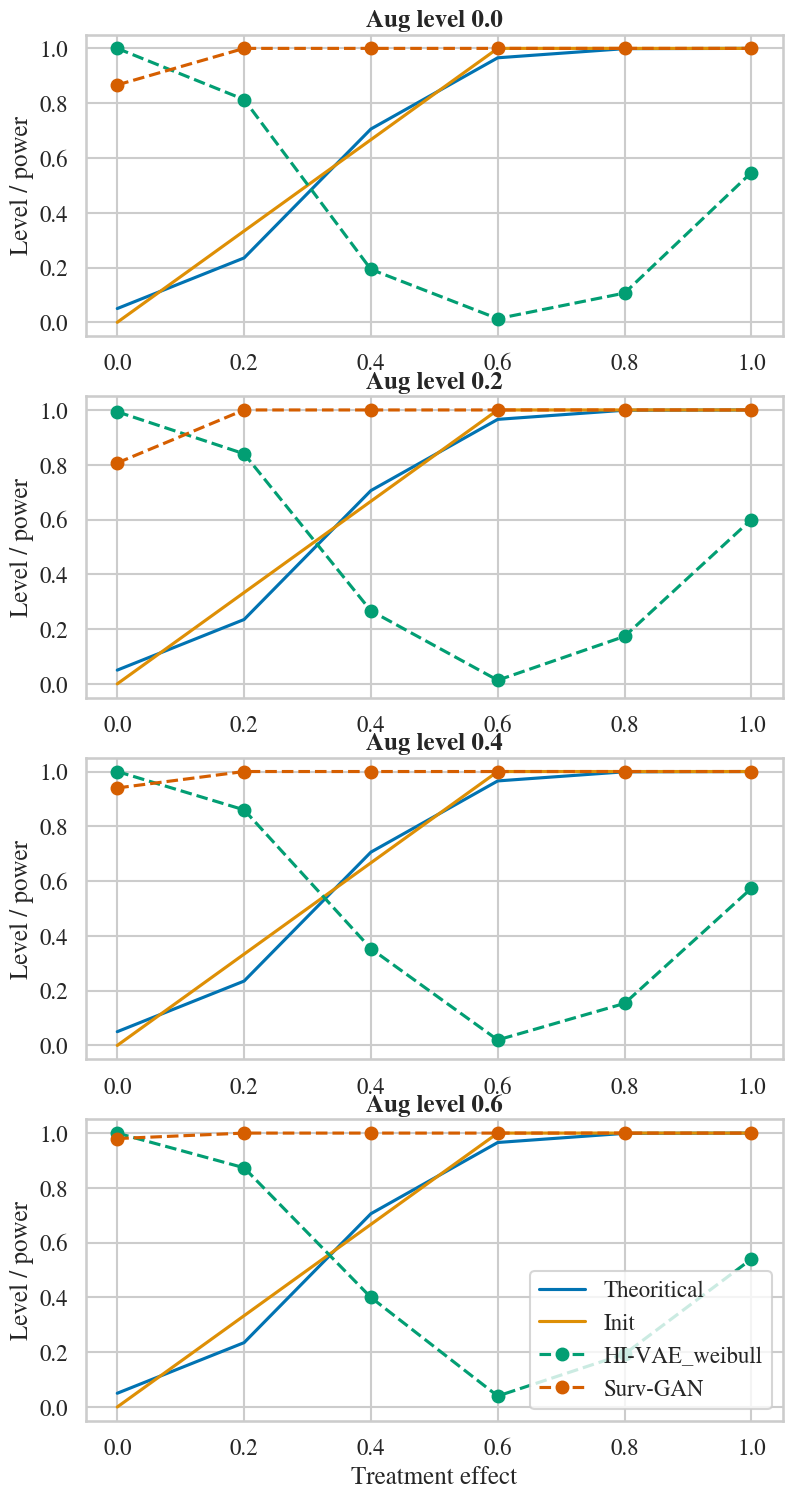

In [3]:
fig, axs = plt.subplots(len(aug_percs), 1, figsize=(9, 18))
for i, aug_perc in enumerate(aug_percs):
    results_ext = results[results.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
    power_theo = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    axs[i].plot(treat_effects, np.array(power_theo), label = "Theoritical")

    results_ext["reject_H0_init"] = results_ext['log_pvalue_init'] > -np.log(0.05)
    power_init = results_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
    axs[i].plot(treat_effects, power_init, '-', label = "Init")

    custom_palette = ['deepskyblue','darkblue','orange', 'red']
    for generator_name in generators_sel:
        results_ext["reject_H0_gen_" + generator_name] = results_ext['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        axs[i].plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

    axs[i].set_ylabel("Level / power")
    axs[i].set_title("Aug level {}".format(aug_perc), fontweight="semibold")
    plt.legend()
plt.xlabel("Treatment effect")
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

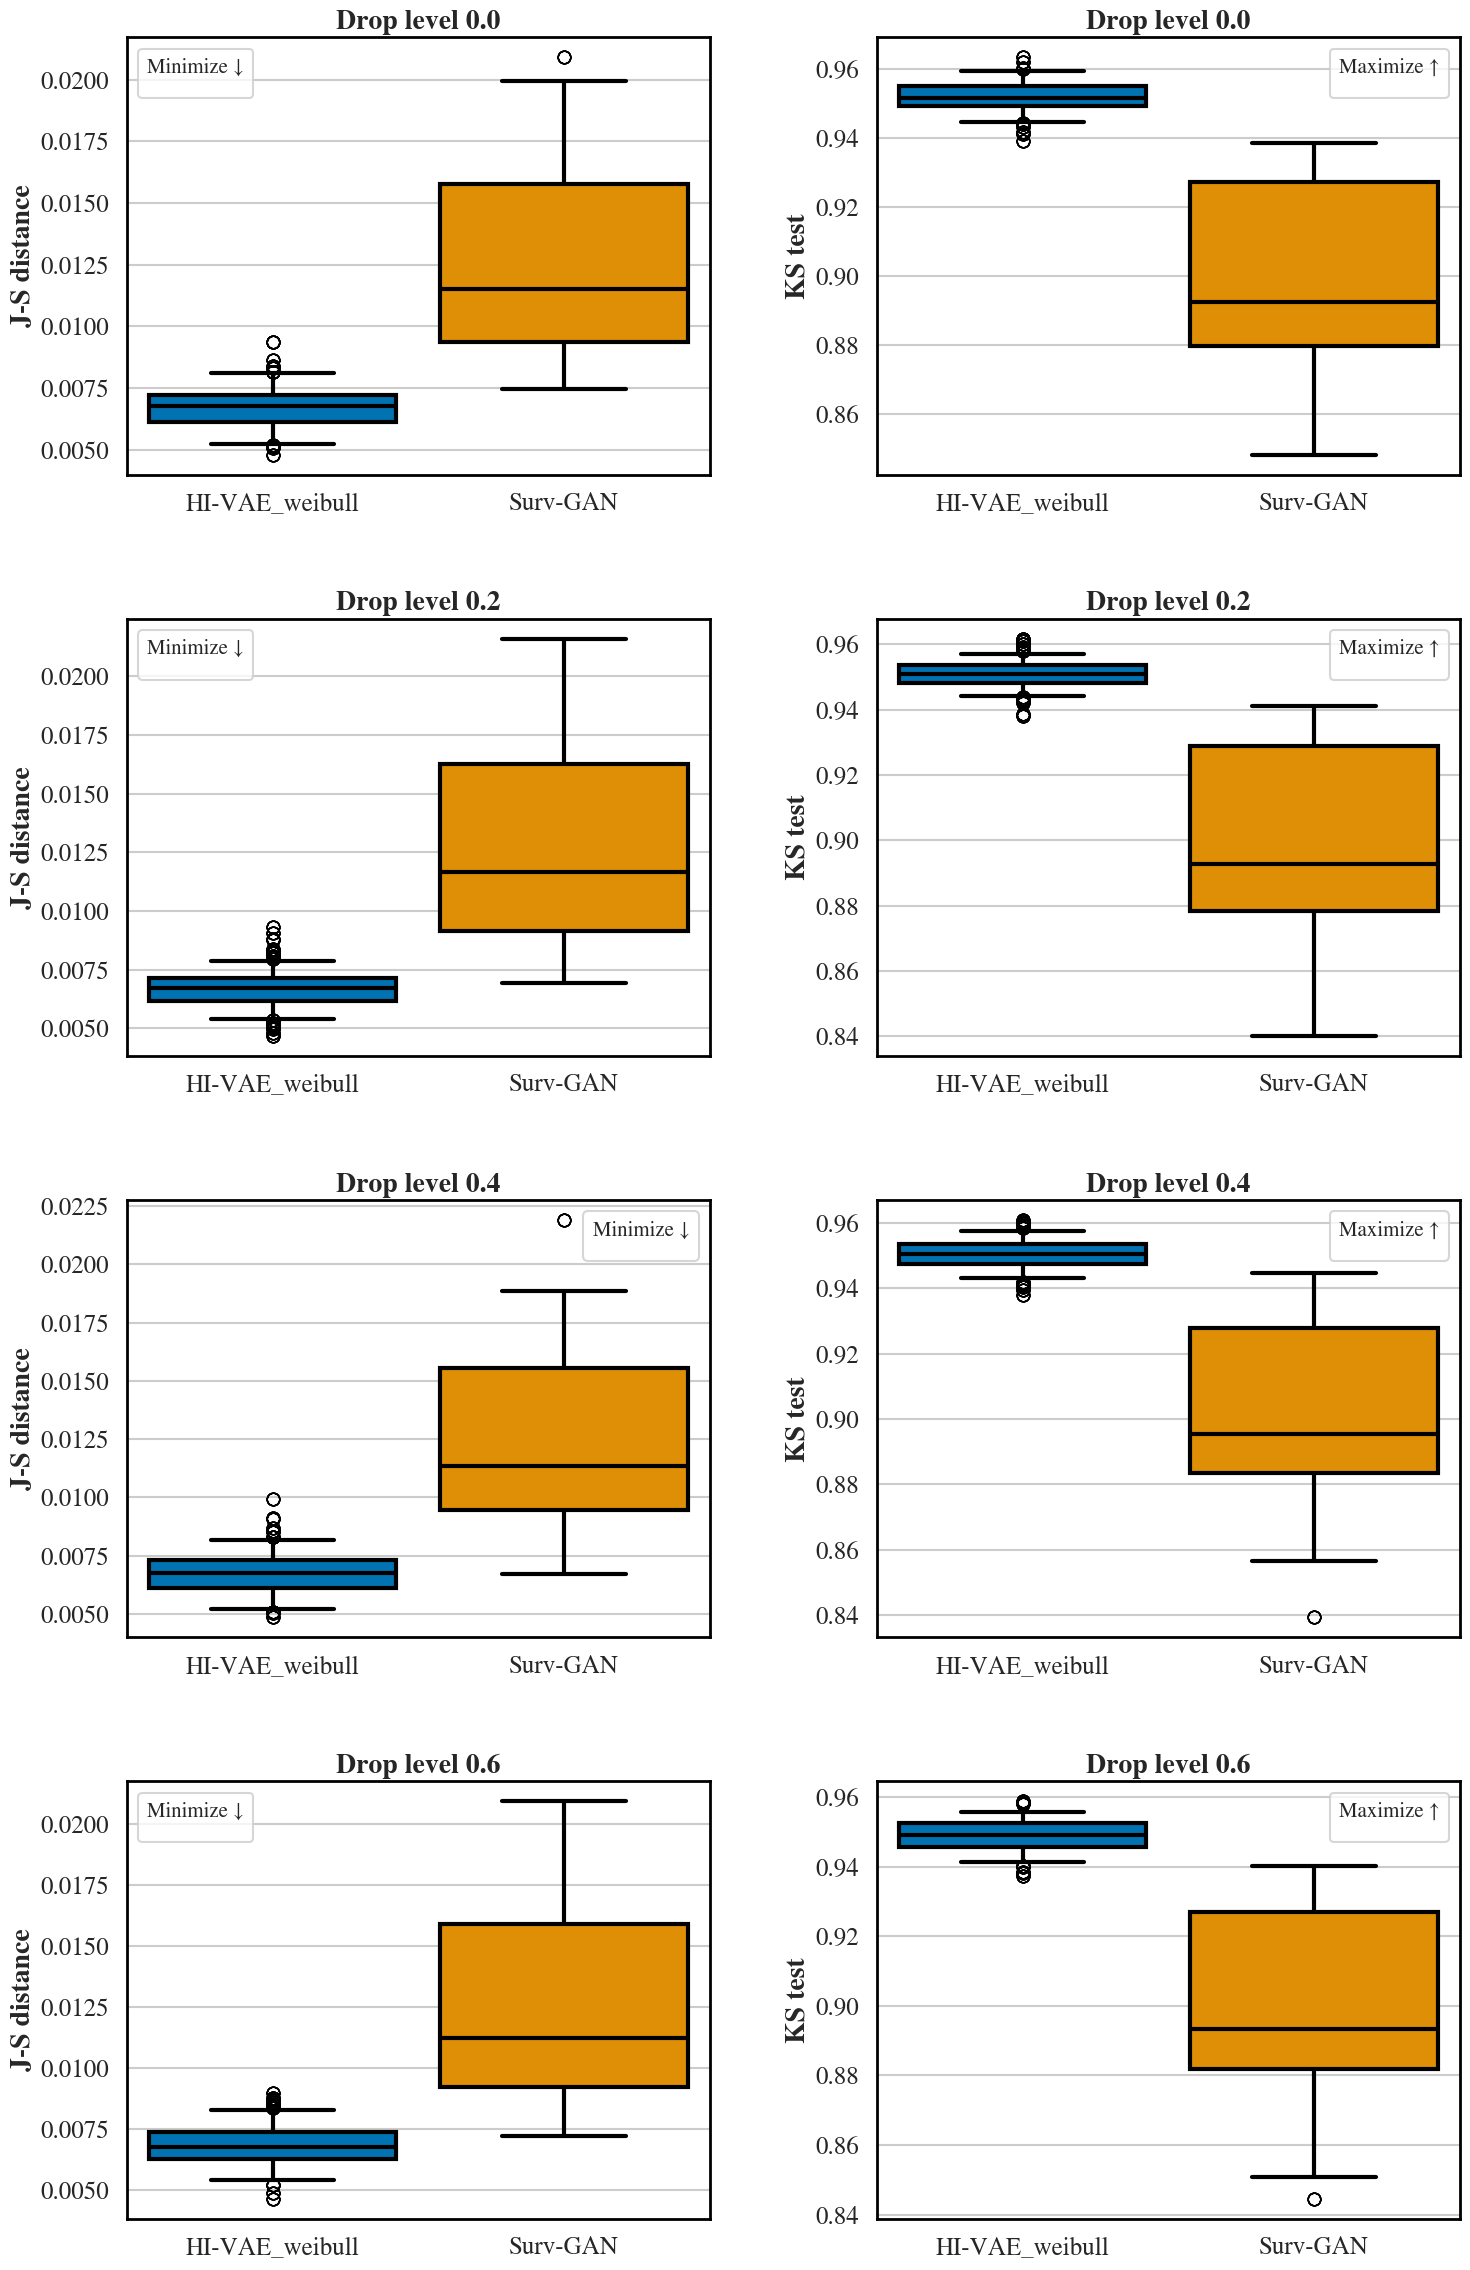

In [4]:
#### SYNTHCITY METRICS 
metrics=[['J-S distance', "min"], ['KS test', "max"]]
num_metrics = len(metrics)
n_learners = len(generators_sel)
fig, axs = plt.subplots(len(aug_percs), num_metrics, figsize=(4 * num_metrics * n_learners, 6 * len(aug_percs)))

if num_metrics == 1:
    axs = [axs]  # ensure axs is iterable

for i, aug_perc in enumerate(aug_percs):
    results_ext = results[results.aug_perc == aug_perc].copy(deep=True)
    for j, ax in enumerate(axs[i]):
        # Format axis spines
        metric_name, opt = metrics[j]
        metric_df = pd.DataFrame()
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext.shape[0], 
                                                            results_ext[metric_name + "_" + generator_name]]).T,
                                                            columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=20, fontweight="semibold")
        ax.set_title("Drop level {}".format(aug_perc), fontsize=20, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
plt.tight_layout(pad=3)
# plt.savefig("./dataset/" + dataset_name + "/results_synthetic_metrics_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

Drop level 0.0


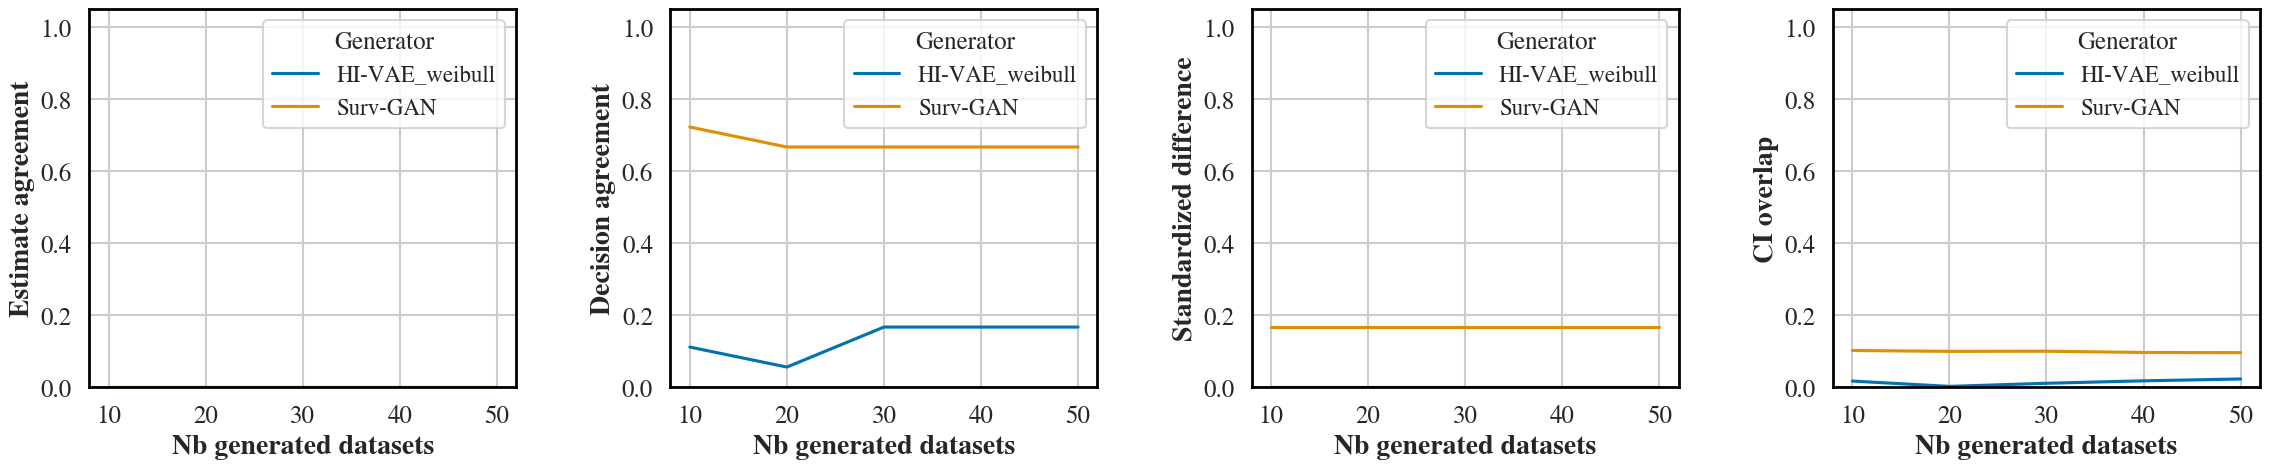

Drop level 0.2


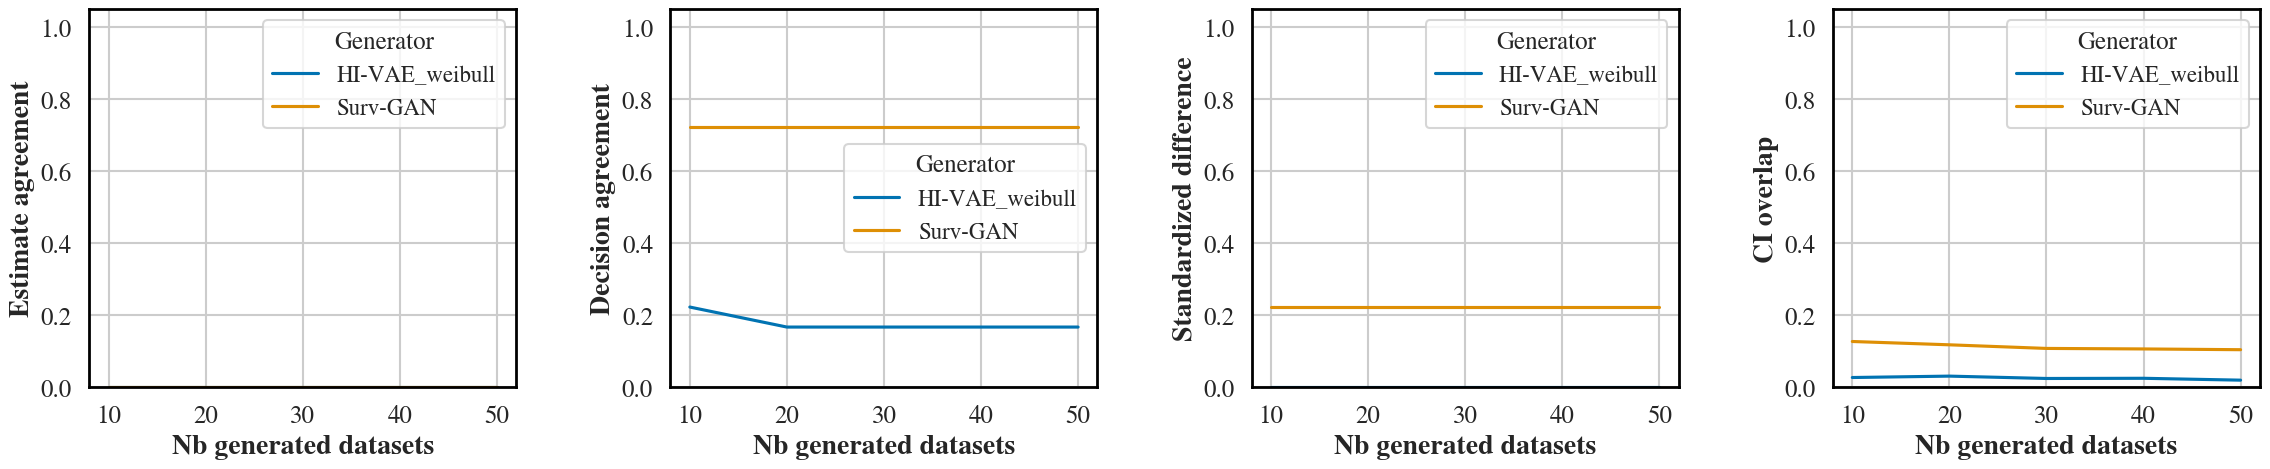

Drop level 0.4


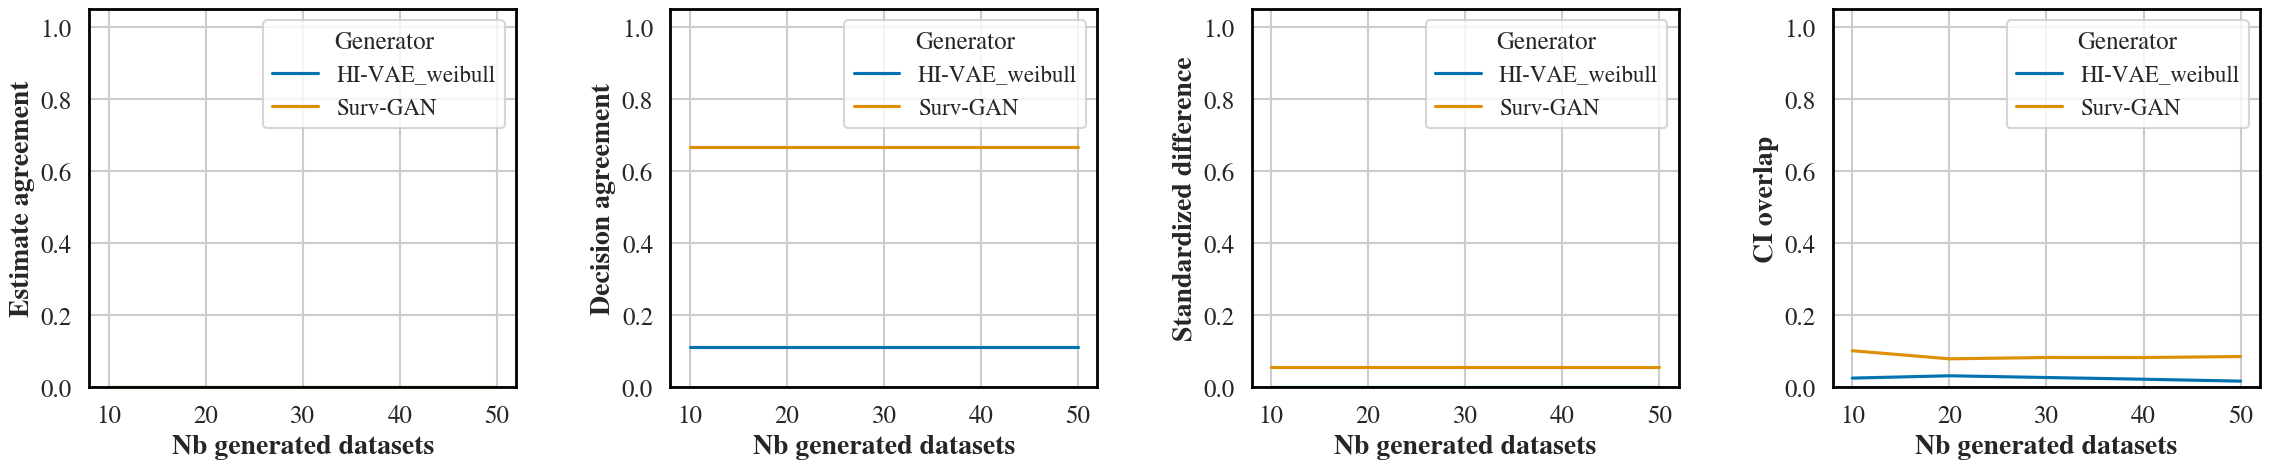

Drop level 0.6


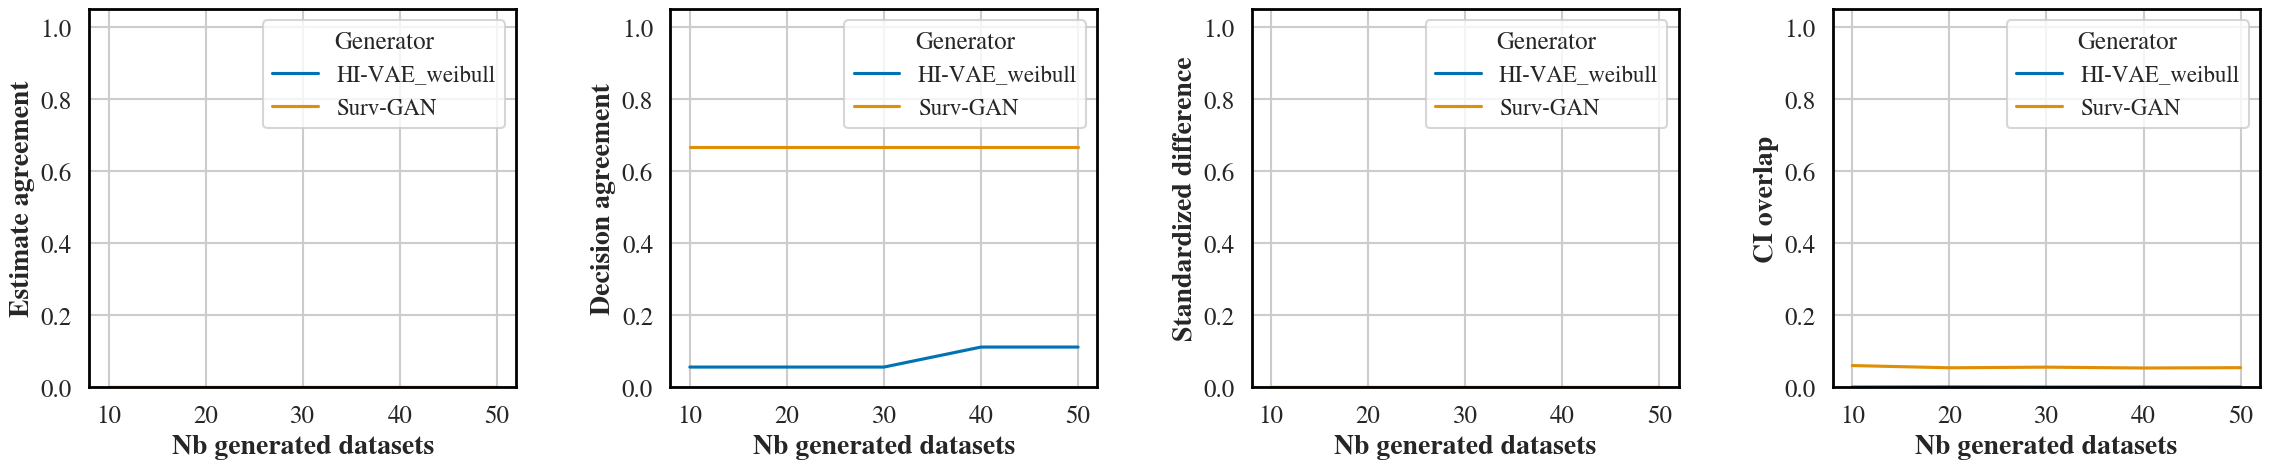

In [5]:
n_MC_exp = 3
from utils.metrics import estimate_agreement, decision_agreement, standardized_difference, ci_overlap
columns = ['time', 'censor', 'treatment']

from utils.visualization import visualize_replicability_perf
# score_df = pd.DataFrame(columns=["Generator", "Treatment_effect", "MC_exp", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
for i, aug_perc in enumerate(aug_percs):
    results_ext = results[results.aug_perc == aug_perc].copy(deep=True)
    score_df = pd.DataFrame(columns=["Generator", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
    for treatment_effect in treat_effects:
        results_treat = results_ext[results_ext.H0_coef == treatment_effect]
        cox_init = results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values
        for m in range(n_MC_exp):
            results_MC = results_treat[(results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]] == cox_init[m]).all(axis=1)]
            coef_init, se_init = results_MC[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values[0]
            ci_init = (coef_init - 1.96 * se_init, coef_init + 1.96 * se_init)

            for generator in generators_sel:
                coef_syn, se_syn = results_MC[["est_cox_coef_" + generator, "est_cox_coef_se_" + generator]].values.T
                max_len_samples = len(coef_syn)
                list_len_samples = np.arange(int(.2 * max_len_samples), max_len_samples, int(.2 * max_len_samples)).tolist()
                if max_len_samples not in list_len_samples:
                    list_len_samples += [max_len_samples]
                for j in list_len_samples:
                    coef_syn_, se_syn_ = np.array(coef_syn)[:j], np.array(se_syn)[:j]
                    coef_syn_mean = coef_syn_.mean()
                    var_syn_mean = (se_syn_**2).mean()
                    # imputation_var_syn = (1 / (len(coef_syn) - 1)) * np.sum([(coef_syn_ - coef_syn_mean)**2 for coef_syn_ in coef_syn])
                    # adjusted_var_syn = (imputation_var_syn / len(coef_syn)) + var_syn_mean
                    adjusted_var_syn = (1/j + 1) * var_syn_mean
                    ci_syn = (coef_syn_mean - 1.96 * np.sqrt(adjusted_var_syn), coef_syn_mean + 1.96 * np.sqrt(adjusted_var_syn))

                    res = [estimate_agreement(ci_init, coef_syn_mean),
                        decision_agreement(coef_init, ci_init, coef_syn_mean, ci_syn),
                        standardized_difference(coef_init, coef_syn_mean, se_init),
                        ci_overlap(ci_init, ci_syn)]

                    # score_df.loc[len(score_df)] = [generator, treatment_effect, m, j] + res
                    score_df.loc[len(score_df)] = [generator, j] + res
    print("Drop level {}".format(aug_perc))
    visualize_replicability_perf(score_df.groupby(['Generator', 'Nb generated datasets'], as_index=False).mean())